<a href="https://colab.research.google.com/github/delemarchand2020/IVADO_MILA_DL/blob/main/Predict_FX_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [1]:
!pip3 install torch

In [2]:
import torch

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.8.1+cu101
GPU Available: True


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

In [4]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import copy
import gc
import math
import time
import os

# Import et préparation des données

##Import des données depuis le Drive

In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
# https://drive.google.com/file/d/1g6GbXJB-NxBt3F-1ftMz2SwzFQ_GU5oZ/view?usp=sharing
# FX_HFData.xlsx
downloaded = drive.CreateFile({'id':"1g6GbXJB-NxBt3F-1ftMz2SwzFQ_GU5oZ"})   # replace the id with id of file you want to access
downloaded.GetContentFile('FX_HFData.xlsx')

## Chargement du fichier et nettoyage des données


In [8]:
df = pd.read_excel('FX_HFData.xlsx',sheet_name='Daily All',dtype={' ': datetime.date, 'USDCAD Curncy': float})
df = df.drop(columns=['EURUSD Curncy','GBPUSD Curncy','USDJPY Curncy','USDCHF Curncy',
                      'AUDUSD Curncy','USDSEK Curncy','USDNOK Curncy','NZDUSD Curncy','USDSGD Curncy'])
df = df.dropna()
df.columns = ['date', 'X']
df.describe()

,X
count,10792.000000
mean,1.264400
std,0.149636
min,0.920350
25%,1.164600
50%,1.270250
75%,1.365000
max,1.613500


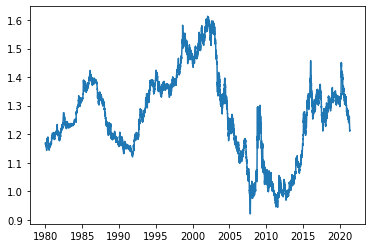

In [9]:
plt.figure()
plt.plot(df['date'],df['X'])

## Création des datasets (train, validate et test)

In [10]:
seq_len = 8 # 7 premiers sont les séquences d'entrée et le huitieme est la cible à prédire
s = pd.Series(df['X'].values)
arr = [s.shift(x).values[::-1][:seq_len] for x in range(len(s))[::-1]]
dfs = []
for row in arr:
  dfs.append(row[::-1])
dfs = dfs[seq_len-1:]

In [11]:
print(dfs[0])
print(dfs[1])
print(len(dfs))

[1.1658 1.1703 1.1687 1.1694 1.1698 1.1686 1.165  1.165 ]
[1.1703 1.1687 1.1694 1.1698 1.1686 1.165  1.165  1.1663]
10785


At this point, we need to divide the dataset into three subsets:

<ol>
<li> <b> Train</b> (60% of the dataset): used to train the classification model. </li>   
<li> <b> Validation</b> (20% of the dataset): used to evaluate hyper-parameters on held-out data. </li>   
<li> <b> Test</b> (20% of the dataset): used to evaluate the generalization performance of the chosen model on held-out data. </li>
</ol>

In [12]:
train, validate, test = np.split(dfs, [int(.6*len(dfs)), int(.8*len(dfs))])

In [13]:
def split_x_y_in_torch(dfs):
  X = []
  Y = []
  for row in dfs:
    X.append([row[0:seq_len-1]])
    Y.append([row[seq_len-1]])
  X = np.array(X)
  Y = np.array(Y)
  return torch.from_numpy(X.transpose(0,2,1)).float(), torch.from_numpy(Y).float()

In [14]:
X_train, y_train = split_x_y_in_torch(train)
X_validate, y_validate = split_x_y_in_torch(validate)
X_test, y_test = split_x_y_in_torch(test)

print(X_train[0])
print(y_train[0])
print(X_validate[0])
print(y_validate[0])
print(X_test[0])
print(y_test[0])

tensor([[1.1658],
        [1.1703],
        [1.1687],
        [1.1694],
        [1.1698],
        [1.1686],
        [1.1650]])
tensor([1.1650])
tensor([[1.2435],
        [1.2337],
        [1.2211],
        [1.2249],
        [1.2256],
        [1.2232],
        [1.2177]])
tensor([1.2223])
tensor([[1.0063],
        [1.0008],
        [1.0014],
        [0.9972],
        [0.9965],
        [0.9988],
        [0.9955]])
tensor([0.9956])


In [15]:
def standardize(X, mean=None, std=None):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      Xs: torch.Tensor standardize.
      mean: float, the mean of X.
      stdev: float, the stdev of X.
    """
    
    X=X.float()

    if mean == None:
      mean = torch.mean(X)
    if std == None:
      std = torch.std(X)
      
    Xs = (X-mean) / std

    return Xs, mean, std

In [16]:
mean = np.mean(dfs)
std = np.std(dfs)

Xs_train, Xs_train_mean, Xs_train_std = standardize(X_train, mean, std)
ys_train, ys_train_mean, ys_train_std = standardize(y_train, mean, std)

Xs_validate, Xs_validate_mean, Xs_validate_std = standardize(X_validate, mean, std)
ys_validate, ys_validate_mean, ys_validate_std = standardize(y_validate, mean, std)

Xs_test, Xs_test_mean, Xs_test_std = standardize(X_test, mean, std)
ys_test, ys_test_mean, ys_test_std = standardize(y_test, mean, std)

print(Xs_train[0])
print(Xs_train_mean)
print(Xs_train_std)
print(ys_train[0])

print(Xs_validate[1])
print(Xs_validate_mean)
print(Xs_validate_std)
print(ys_validate[1])

print(Xs_test[200])
print(Xs_test_mean)
print(Xs_test_std)
print(ys_test[200])

tensor([[-0.6591],
        [-0.6291],
        [-0.6397],
        [-0.6351],
        [-0.6324],
        [-0.6404],
        [-0.6645]])
1.2644476579740378
0.14966483681598952
tensor([-0.6645])
tensor([[-0.2051],
        [-0.2896],
        [-0.2639],
        [-0.2592],
        [-0.2759],
        [-0.3127],
        [-0.2816]])
1.2644476579740378
0.14966483681598952
tensor([-0.2572])
tensor([[-1.4830],
        [-1.4622],
        [-1.4876],
        [-1.4582],
        [-1.4472],
        [-1.4492],
        [-1.4361]])
1.2644476579740378
0.14966483681598952
tensor([-1.4616])


# Implémentation du modèle RNN

## Modèle RNN
Implement an RNN network using the [torch.nn.RNN()](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) class. The input arguments are the following:
- **input_dim**: the dimension of the input data
- **output_dim**: the dimension of the output data
- **hidden_size**: the size of the hidden state of the RNN
- **n_layers**: the number of layers of the RNN.

In [17]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        self.rnn_layer = torch.nn.RNN(input_size=input_dim,hidden_size=hidden_size,num_layers=n_layers)
        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)
        self.print_debug_flag = False

    def print_debug(self,text,var):
      if self.print_debug_flag == True:
        print(text,var)

    def forward(self, x):
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        self.print_debug('x:',x)

        x = torch.transpose(x, 0, 1)

        self.print_debug('x\':',x)

        output, hidden = self.rnn_layer(x) #hidden c'est le dernier h (vecteur)
                                            # si on veut initialiser un autre rnn avec les parametres déjà appris

        self.print_debug('hidden:',hidden)
        self.print_debug('output:',output)
        self.print_debug('output[-1]:',output[-1])
        self.print_debug('linear_layer(output):',self.linear_layer(output))
        self.print_debug('linear_layer(output[-1]):',self.linear_layer(output[-1]))

        output = output[-1]
        pred = self.linear_layer(output)
        
        self.print_debug('pred:',pred)

        return pred

In [18]:
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Declaration of the RNN model
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_rnn = model_rnn.to(device)

# save its initial weights (we do this so that, if we run the model
# multiple time, we always start from these randomly initialized weights)
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

In [19]:
# Transfer the data to the proper device
Xs_train = Xs_train.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_rnn(Xs_train)
print("Size of input data: {}".format(Xs_train.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)
        
# x has size of (n_samples=batch_size, seq_len, input_dim)
# The RNN's input must be of size (seq_len, batch_size, input_dim)
print(Xs_train.shape)
Xs_train_t = torch.transpose(Xs_train, 0, 1)
print(Xs_train_t.shape)
print(ys_train[1])
print(y_pred[1])

Size of input data: torch.Size([6471, 7, 1])
Size of predictions: torch.Size([6471, 1])
torch.Size([6471, 7, 1])
torch.Size([7, 6471, 1])
tensor([-0.6558])
tensor([-0.2965], device='cuda:0', grad_fn=<SelectBackward>)


## Dataset
We will use PyTorch's DataLoader objects to efficiently manipulate our data.

In [20]:
batch_size = 4

# dataloader for the training dataset
train_loader = DataLoader(TensorDataset(Xs_train, ys_train), batch_size, shuffle=True)

# prepare the dataloader for the validation dataset
valid_loader = DataLoader(TensorDataset(Xs_validate, ys_validate), batch_size)

# prepare the dataloader for the test dataset
test_loader = DataLoader(TensorDataset(Xs_test, ys_test), batch_size)

## Training loop

In [21]:
learning_rate = 0.01

# Define the loss function
loss_fun = torch.nn.MSELoss()

# Define the Optimizer
def get_optimizer(model):
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  return optimizer

In [22]:
# Define function to encapsulate main training loop
def train_model(model, init_weights, optimizer):

    since = time.time()

    train_loss_history = []
    valid_loss_history = []

    n_epoch = 25

    model.load_state_dict(init_weights)

    print("Start training")

    for epoch in range(n_epoch):
        
        train_loss = 0
        train_n_iter = 0
        
        # Set model to train mode
        model.train()
        torch.set_grad_enabled(True)
        
        # Iterate over train data
        for x, y in train_loader:  

            
            # Put tensors on device (GPU when available)
            x = x.to(device)
            y = y.to(device)

            # Zero the gradient buffer
            optimizer.zero_grad()
            
            # Perform the Forward operation
            outputs = model(x)
            
            # Calculate the loss using the loss function
            loss = loss_fun(outputs, y)
            
            # Perform the Backward operation
            loss.backward()
            
            # Perform the Optimization step
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            train_n_iter += 1
        
        valid_loss = 0
        valid_n_iter = 0
        
        # Set model to evaluate mode
        model.eval()
        with torch.no_grad():
        
            # Iterate over valid data
            for x, y in valid_loader:  
            
                # Put tensors on device (GPU when available)
                x = x.to(device)
                y = y.to(device)
            
                # Perform the Forward operation
                outputs = model(x)
                
                # Calculate the loss using the loss fun function
                loss = loss_fun(outputs,y)
            
                # Statistics
                valid_loss += loss.item()
                valid_n_iter += 1
        
        train_loss_history.append(train_loss / train_n_iter)
        valid_loss_history.append(valid_loss / valid_n_iter)


        print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
              .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

    time_elapsed = time.time() - since

    print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return train_loss_history, valid_loss_history

In [23]:
# Perform training of the RNN model
optimizer_rnn = get_optimizer(model_rnn)
loss_history = train_model(model_rnn, init_rnn_weights, optimizer_rnn)

# Save loss history for later
rnn_train_loss_history, rnn_valid_loss_history = loss_history

Start training
Epoch  1 | Training loss = 0.02301 | Validation loss = 0.08056 
Epoch  2 | Training loss = 0.00185 | Validation loss = 0.04610 
Epoch  3 | Training loss = 0.00150 | Validation loss = 0.03516 
Epoch  4 | Training loss = 0.00140 | Validation loss = 0.02741 
Epoch  5 | Training loss = 0.00133 | Validation loss = 0.02274 
Epoch  6 | Training loss = 0.00128 | Validation loss = 0.02554 
Epoch  7 | Training loss = 0.00127 | Validation loss = 0.02267 
Epoch  8 | Training loss = 0.00122 | Validation loss = 0.02471 
Epoch  9 | Training loss = 0.00119 | Validation loss = 0.02105 
Epoch 10 | Training loss = 0.00118 | Validation loss = 0.02325 
Epoch 11 | Training loss = 0.00114 | Validation loss = 0.02262 
Epoch 12 | Training loss = 0.00112 | Validation loss = 0.02072 
Epoch 13 | Training loss = 0.00109 | Validation loss = 0.01894 
Epoch 14 | Training loss = 0.00108 | Validation loss = 0.01973 
Epoch 15 | Training loss = 0.00108 | Validation loss = 0.01889 
Epoch 16 | Training loss 

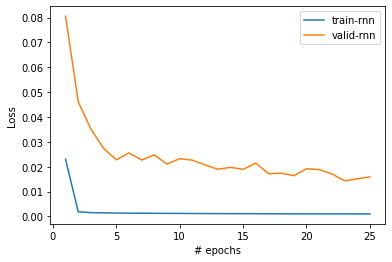

In [24]:
# Plot training and validation curve
n_epoch = 25
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validation pré-production du modèle

In [51]:
def print_mean_abs_error(X, Y, idx=None):
    xs = X.numpy()
    ys = Y.numpy()

    if idx == None:
      diff = abs(xs-ys)
      print(f"Absolute mean error between target[:] et prediction[:] = {np.mean(diff)}")
    else:
      diff = abs(xs[idx]-ys[idx])
      print(f"Absolute mean error between target[{idx}] et prediction[{idx}] = {np.mean(diff)}")

## Validation avec le dataset de tests

The RNN's test mean squared error is 0.003


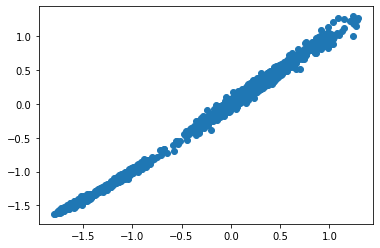

In [25]:
# Put sequence data on device (GPU when available)
Xs_test = Xs_test.to(device)

# Put target data on device (GPU when available)
ys_test = ys_test.to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(Xs_test)

# Compute the loss of the RNN-based model using the loss function
loss_test_rnn = loss_fun(ypred_rnn, ys_test)

print(f"The RNN's test mean squared error is {float(loss_test_rnn):2.3f}")

plt.scatter(ys_test.cpu().detach().numpy(),ypred_rnn.cpu().detach().numpy())

In the following cell, we use the model to predict Fx price

In [53]:
Xs_test = Xs_test.cpu()
ypred_rnn = ypred_rnn.cpu()
ys_test = ys_test.cpu()

# Unstandardize  xtest ytest
xtest_unstd = Xs_test*std + mean

ys_test_unstd = ys_test*std + mean

# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + mean

# sample a random number from the examples above:
idx = np.random.randint(len(ys_test))

print("")
print("Example RNN:")
print("")
print(f"xtest[{idx}] = {xtest_unstd.detach()[idx]}")
print(f"ys_test[{idx}] = {ys_test_unstd.detach()[idx]}\n ypred[{idx}] = {ypred_unstd.detach()[idx]}")

print_mean_abs_error(ys_test_unstd.detach(), ypred_unstd.detach(), idx)
print_mean_abs_error(ys_test_unstd.detach(), ypred_unstd.detach())


Example RNN:

xtest[1602] = tensor([[1.3305],
        [1.3364],
        [1.3429],
        [1.3404],
        [1.3381],
        [1.3409],
        [1.3438]])
ys_test[1602] = tensor([1.3349])
 ypred[1602] = tensor([1.3432])
Absolute mean error between target[1602] et prediction[1602] = 0.008292913436889648
Absolute mean error between target[:] et prediction[:] = 0.005977938417345285


## Validation avec des séquences unitaires

In [64]:
idx = 2

# Put sequence data on device (GPU when available)
Xs_unit = Xs_train[idx:idx+1,:,:].to(device)

# Put target data on device (GPU when available)
ys_unit = ys_train[idx].to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(Xs_unit)

Xs_unit = Xs_unit.cpu()
ypred_rnn = ypred_rnn.cpu()
ys_unit = ys_unit.cpu()

# Unstandardize  xtest ytest
xunit_unstd = Xs_unit*std + mean

ys_unit_unstd = ys_unit*std + mean

# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + mean

print(f"xtest[{idx}] = {xunit_unstd.detach()}")
print(f"ys_test[{idx}] = {ys_unit_unstd.detach()}\n ypred[{idx}] = {ypred_unstd.detach()}")

print_mean_abs_error(ys_unit_unstd.detach(), ypred_unstd.detach(), 0)

xtest[2] = tensor([[[1.1687],
         [1.1694],
         [1.1698],
         [1.1686],
         [1.1650],
         [1.1650],
         [1.1663]]])
ys_test[2] = tensor([1.1658])
 ypred[2] = tensor([[1.1655]])
Absolute mean error between target[0] et prediction[0] = 0.00030815601348876953


# Zone de tests (hors projet)

In [28]:
X = []
Y = []

for row in dfs:
  X.append([row[0:seq_len-1]])
  Y.append([row[seq_len-1]])
X = np.array(X)
Y = np.array(Y)
print(X[0])
torch_X = torch.from_numpy(X.transpose(0,2,1)).float()
print(torch_X.shape)
print(torch_X[0,:,0])

[[1.1658 1.1703 1.1687 1.1694 1.1698 1.1686 1.165 ]]
torch.Size([10785, 7, 1])
tensor([1.1658, 1.1703, 1.1687, 1.1694, 1.1698, 1.1686, 1.1650])
